In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
df = pd.read_json('datascience_assignment_data.json')

In [3]:
df.head()

,distance,preorder,timestamp,tz,venue_tags,weather
0,3.123568,False,2018-04-10 09:36:53.754,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
1,2.489746,False,2018-04-10 10:27:39.279,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
2,1.378161,False,2018-04-10 10:35:22.101,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
3,2.390313,False,2018-04-10 12:32:17.173,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
4,2.493781,False,2018-04-10 13:13:56.298,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny


In [4]:
#preorder is always false so we can drop it from consideration
df['preorder'].unique()

array([False])

In [5]:
df = df.drop(['preorder'], axis=1)

In [6]:
#timezone is always constant Europe/Helsinki so we can drop it from consideration
s = set( val for dic in df['tz'].values for val in dic.values())
s

{'Europe/Helsinki'}

In [7]:
df = df.drop(['tz'], axis=1)

In [8]:
#Class distribution of venue tags is highly imbalanced to a few classes so we can consider only the top 5 classes
venue_tags = df['venue_tags'].apply(pd.Series).stack().value_counts()
value_tags_names = venue_tags.index.tolist()
venue_tags

sushi          2590
japanese       2359
gourmet        2359
fresh          1130
fish            233
pita              6
lebanese          5
fast              5
meze              5
salad             5
lunch             5
vegetarian        4
sandwich          4
hangover          3
noodles           3
pizza             3
wrap              3
cheap             3
spicy             3
smoothie          3
asian             3
american          2
vietnamese        2
meat              2
soup              2
italian           2
meatballs         2
family            1
healthy           1
dessert           1
fafas             1
artisan           1
hamburger         1
chicken           1
falafel           1
coffee            1
fries             1
café              1
vegan             1
rice              1
thai              1
napolese          1
street food       1
dtype: int64

In [9]:
value_tags_names[:5]

['sushi', 'japanese', 'gourmet', 'fresh', 'fish']

In [10]:
#With weather the class distirubtion is much more even
#possible preposition to use the app more when it is raining
df['weather'].value_counts()

rain            955
sunny           740
mostly_sunny    580
overcast        332
Name: weather, dtype: int64

In [105]:
#Each day (and hour) has only one weather type
print(df.to_string())

      distance               timestamp                                         venue_tags       weather
0     3.123568 2018-04-10 09:36:53.754                         [sushi, japanese, gourmet]         sunny
1     2.489746 2018-04-10 10:27:39.279                                      [sushi, fish]         sunny
2     1.378161 2018-04-10 10:35:22.101                         [sushi, japanese, gourmet]         sunny
3     2.390313 2018-04-10 12:32:17.173                                      [sushi, fish]         sunny
4     2.493781 2018-04-10 13:13:56.298                         [sushi, japanese, gourmet]         sunny
5     2.384462 2018-04-10 13:20:33.605                                      [sushi, fish]         sunny
6     2.598420 2018-04-10 14:31:12.864                                      [sushi, fish]         sunny
7     1.343303 2018-04-10 14:50:14.454                         [sushi, japanese, gourmet]         sunny
8     2.890603 2018-04-10 17:08:15.984                         [

In [11]:
tag_df = pd.DataFrame(0, index=np.arange(len(df)), columns=value_tags_names)
venue_tags_lists = df.venue_tags.tolist()

for index, row in tag_df.iterrows():
    for tag in value_tags_names:
        if tag in venue_tags_lists[index]: 
            row[tag] = 1

In [12]:
tag_df = tag_df[['sushi', 'japanese', 'gourmet', 'fresh', 'fish']]

In [13]:
df = pd.concat([df,tag_df], axis=1)

In [14]:
df = df.drop(['venue_tags'], axis=1)

In [15]:
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0


In [16]:
df['weather_numeric'] = pd.Categorical(df.weather).codes

In [18]:
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['week'] = df['timestamp'].dt.week
df['month'] = df['timestamp'].dt.month
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0,3,9,1,15,4
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1,3,10,1,15,4
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0,3,10,1,15,4
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1,3,12,1,15,4
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0,3,13,1,15,4


## Relationship between weather and order amount

In [67]:
#Approximation on how many hours are of each weather type
hourly_sum = df.groupby([pd.Grouper(key='timestamp',freq='H'),df.weather]).size().reset_index(name='count')
hourly_sum[:10]

,timestamp,weather,count
0,2018-04-10 09:00:00,sunny,1
1,2018-04-10 10:00:00,sunny,2
2,2018-04-10 12:00:00,sunny,1
3,2018-04-10 13:00:00,sunny,2
4,2018-04-10 14:00:00,sunny,2
5,2018-04-10 17:00:00,sunny,2
6,2018-04-11 09:00:00,rain,1
7,2018-04-11 10:00:00,rain,3
8,2018-04-11 13:00:00,rain,1
9,2018-04-11 14:00:00,rain,3


In [68]:
hourly_sum_rain = hourly_sum[hourly_sum['weather'] == 'rain'].shape[0]
hourly_sum_sunny = hourly_sum[hourly_sum['weather'] == 'sunny'].shape[0]
hourly_sum_mostly_sunny = hourly_sum[hourly_sum['weather'] == 'mostly_sunny'].shape[0]
hourly_sum_overcast = hourly_sum[hourly_sum['weather'] == 'overcast'].shape[0]

In [69]:
print("orders in rain: " + str(955 / hourly_sum_rain) + " per hour")

orders in rain: 2.8851963746223563 per hour


In [70]:
print("orders in sunny: " + str(740 / hourly_sum_sunny) + " per hour")

orders in sunny: 2.364217252396166 per hour


In [71]:
print("orders in mostly sunny : " + str(580 / hourly_sum_mostly_sunny) + " per hour")

orders in mostly sunny : 2.600896860986547 per hour


In [72]:
print("orders in mostly overcast : " + str(332 / hourly_sum_overcast) + " per hour")

orders in mostly overcast : 2.8620689655172415 per hour


__Conclusion: Worse weather attracts more customers to the application__

## Relationship between time and order amount

In [57]:
#Adjust freq to W for weekly orders and M to monthly orders
daily_sum = df.groupby(pd.Grouper(key='timestamp',freq='D')).count()
daily_sum.rename(columns={'distance':'amount'}, inplace=True)

In [58]:
daily_sum.head()

,amount,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
timestamp,,,,,,,,,,,,
2018-04-10,10,10,10,10,10,10,10,10,10,10,10,10
2018-04-11,12,12,12,12,12,12,12,12,12,12,12,12
2018-04-12,14,14,14,14,14,14,14,14,14,14,14,14
2018-04-13,20,20,20,20,20,20,20,20,20,20,20,20
2018-04-14,27,27,27,27,27,27,27,27,27,27,27,27


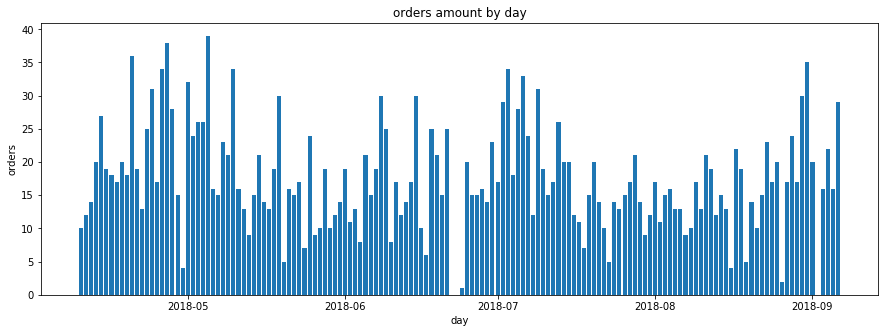

In [59]:
plt.figure(figsize=(15,5))
plt.bar(daily_sum.index, daily_sum.amount)
plt.xlabel('day')
plt.ylabel('orders')
plt.title('orders amount by day')
plt.show()

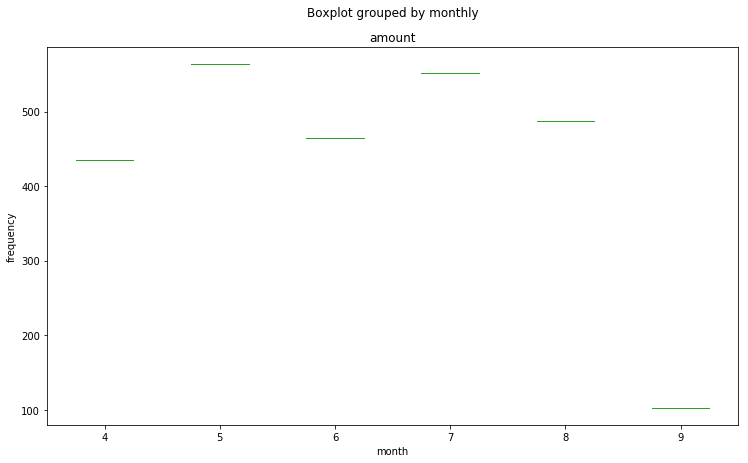

In [66]:
monthly_sum = df.groupby(pd.Grouper(key='timestamp',freq='M')).count()
monthly_sum.rename(columns={'distance':'amount'}, inplace=True)

monthly_sum['monthly'] = monthly_sum.index.month
monthly_sum.groupby(['monthly']).amount.sum()


monthly_sum.boxplot(column='amount', by='monthly', figsize=(12,7), grid=False)
plt.xlabel('month')
plt.ylabel('frequency')
plt.show()

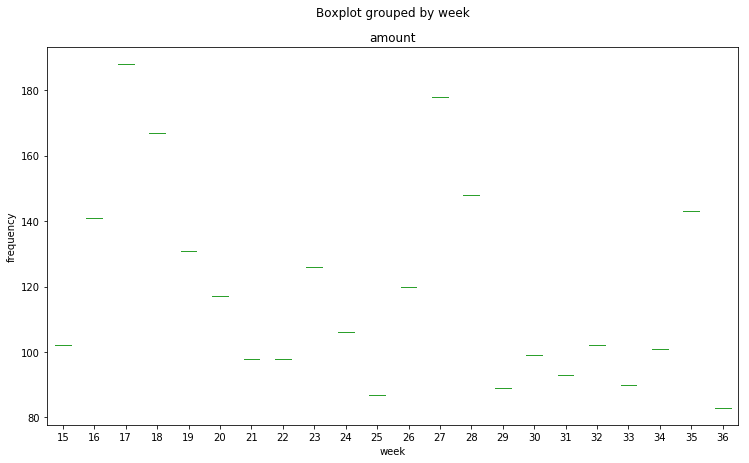

In [65]:
weekly_sum = df.groupby(pd.Grouper(key='timestamp',freq='W')).count()
weekly_sum.rename(columns={'distance':'amount'}, inplace=True)

#add day column to group_by
weekly_sum['week'] = weekly_sum.index.week

#application use increases till friday after which it decreases
weekly_sum.groupby(['week']).amount.sum()


weekly_sum.boxplot(column='amount', by='week', figsize=(12,7), grid=False)
plt.xlabel('week')
plt.ylabel('frequency')
plt.show()

C:\Users\Simo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


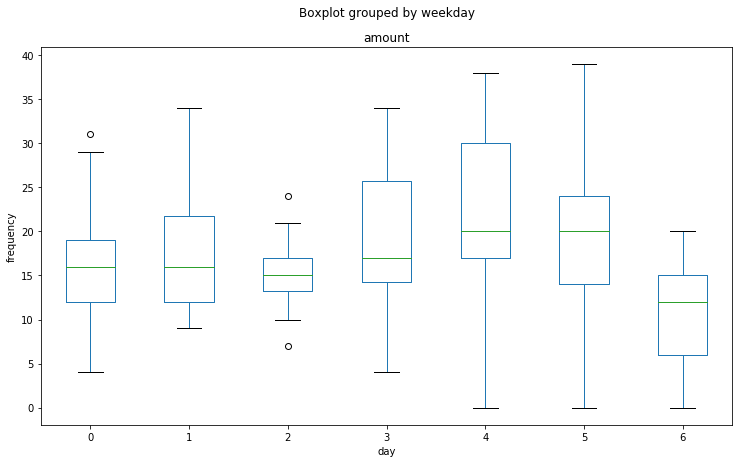

In [60]:
#add day column to group_by
daily_sum['weekday'] = daily_sum.index.weekday

#application use increases till friday after which it decreases
daily_sum.groupby(['weekday']).amount.sum()


daily_sum.boxplot(column='amount', by='weekday', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

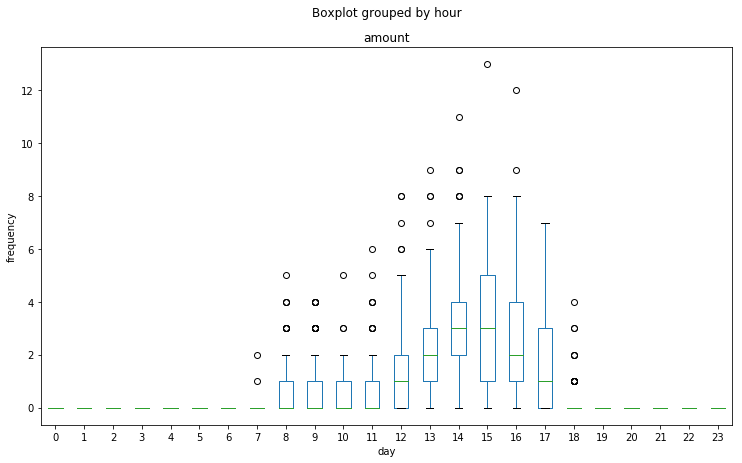

In [61]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
hourly_sum.rename(columns={'distance':'amount'}, inplace=True)

#add day column to group_by
hourly_sum['hour'] = hourly_sum.index.hour

#application use increases till friday after which it decreases
hourly_sum.groupby(['hour']).amount.sum()


hourly_sum.boxplot(column='amount', by='hour', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

## Relationship between distance and weather

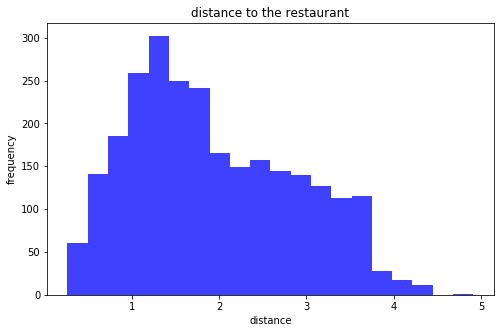

In [305]:
plt.figure(figsize=(8,5))
plt.hist(df.distance,20, facecolor='blue', alpha=0.75)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('distance to the restaurant')
plt.show()

In [121]:
distance_weather_rain = df.loc[df['weather'] == 'rain']
distance_weather_sunny = df.loc[df['weather'] == 'sunny']
distance_weather_mostly_sunny = df.loc[df['weather'] == 'mostly_sunny']
distance_weather_overcast = df.loc[df['weather'] == 'overcast']

In [122]:
#weather does not seem to have a large effect on user distance to the restaurant 
for weather in [distance_weather_rain, distance_weather_sunny,distance_weather_mostly_sunny,distance_weather_overcast]:
    print(str(weather['weather'].iloc[0]) + " median: " + str(weather.median().distance))

rain median: 1.7960506616
sunny median: 1.76208313405
mostly_sunny median: 1.6918655821000002
overcast median: 1.80655828565


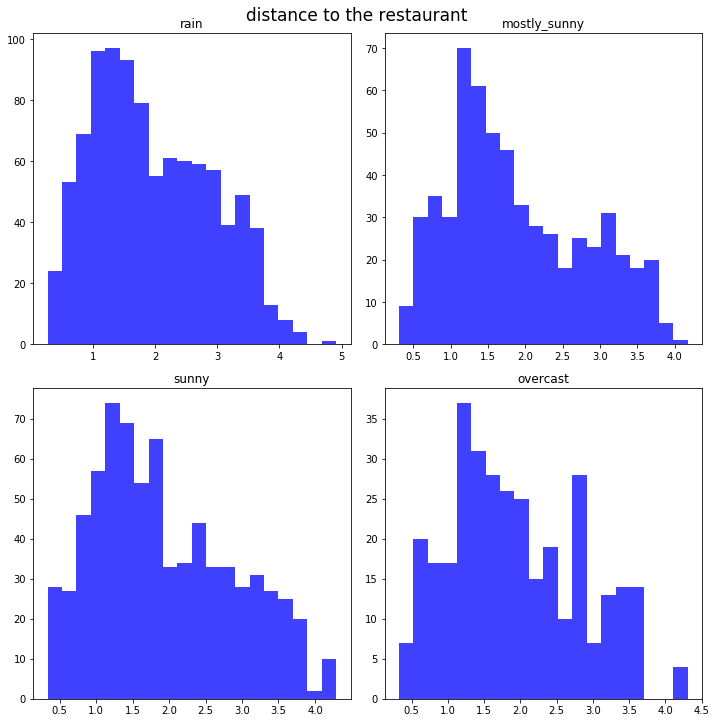

In [123]:
#This can be also seen in the histograms
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True,figsize=(10, 10))

# We can set the number of bins with the `bins` kwarg
axs[0,0].hist(distance_weather_rain.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,0].hist(distance_weather_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[0,1].hist(distance_weather_mostly_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,1].hist(distance_weather_overcast.distance, bins=20, facecolor='blue', alpha=0.75)

axs[0,0].set_title('rain')
axs[1,0].set_title('sunny')
axs[0,1].set_title('mostly_sunny')
axs[1,1].set_title('overcast')

fig.suptitle('distance to the restaurant', y=1.00, fontsize=17)

plt.show()

# Predictions for app usage

##  RandomForestRegressor

In [ ]:
#https://medium.com/turo-engineering/how-not-to-use-random-forest-265a19a68576
#https://stats.stackexchange.com/questions/175908/random-forest-regression-and-trended-time-series
#https://www.quora.com/What-are-some-practical-tricks-tweeks-techniques-for-applying-random-forest-on-time-series-regression
#https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [19]:
df.head()

,distance,timestamp,weather,sushi,japanese,gourmet,fresh,fish,weather_numeric,hour,weekday,week,month
0,3.123568,2018-04-10 09:36:53.754,sunny,1,1,1,0,0,3,9,1,15,4
1,2.489746,2018-04-10 10:27:39.279,sunny,1,0,0,0,1,3,10,1,15,4
2,1.378161,2018-04-10 10:35:22.101,sunny,1,1,1,0,0,3,10,1,15,4
3,2.390313,2018-04-10 12:32:17.173,sunny,1,0,0,0,1,3,12,1,15,4
4,2.493781,2018-04-10 13:13:56.298,sunny,1,1,1,0,0,3,13,1,15,4


In [244]:
df_predict = df[['hour', 'weekday']]

df_predict = df_predict.groupby(df_predict.columns.tolist()).size().reset_index().\
    rename(columns={0:'amount'})

df_predict.head()

,hour,weekday,amount
0,7,2,2
1,7,3,1
2,8,0,23
3,8,1,16
4,8,2,16


In [245]:
X = df_predict[['hour','weekday']]
y = df_predict.amount

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=333)

In [241]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=333)

In [242]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [20,50,100,200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2,3,4,5],
               'min_samples_split': [2,3,4,5],
               'min_samples_leaf': [1,2,4,5]}


rf = RandomForestRegressor()
rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 5, verbose=2, n_jobs = 4)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  35 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 277 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 683 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 1249 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 1979 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 2553 out of 2560 | elapsed:   49.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 2560 out of 2560 | elapsed:   49.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [20, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [230]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 20}

In [243]:
rf_cv.score(X_test, y_test)

0.23643235306144572

In [233]:
rf = RandomForestRegressor(n_estimators= 20, min_samples_split= 3, min_samples_leaf=4, max_features='sqrt', max_depth=5)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.3321871899521328

In [234]:
rf.score(X_test, y_test)

0.2165178752308926

In [236]:
#Most important features
#hour
#week
#weekday
#weather
#month
print(rf.feature_importances_)

[0.09346847 0.56566149 0.09217584 0.19511624 0.05357795]
